In [182]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from adaptive_latents import proSVD, CenteringTransformer, Pipeline, NumpyTimedDataSource, AnimationManager, KernelSmoother, datasets
import adaptive_latents
import itertools
import tqdm.notebook as tqdm

rng = np.random.default_rng()


In [127]:
d = datasets.Naumann24uDataset(datasets.Naumann24uDataset.sub_datasets[-1])
d.sub_dataset

'output_012824_ds6_fish3'

## Experiment structure

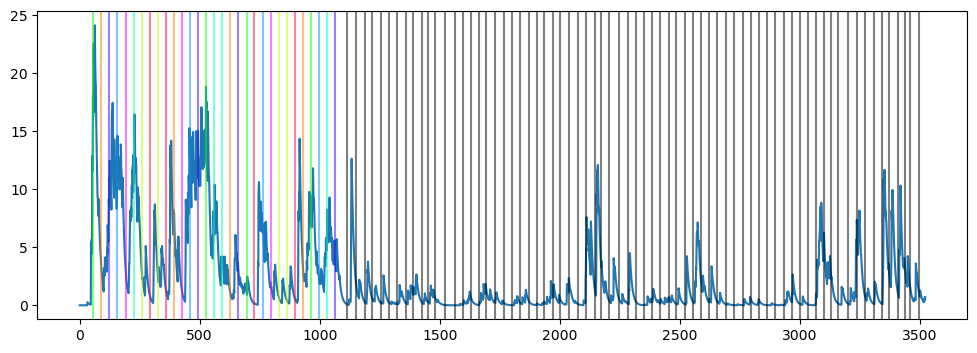

In [128]:
neuron_index = 65

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(d.C[neuron_index,:])
for idx, (time, angle, _) in d.visual_stimuli.iterrows():
    plt.axvline(time, color=d.a2c(angle), alpha=.5)
for time in d.opto_stimulations['sample']:
    plt.axvline(time, color='k', alpha=.5)

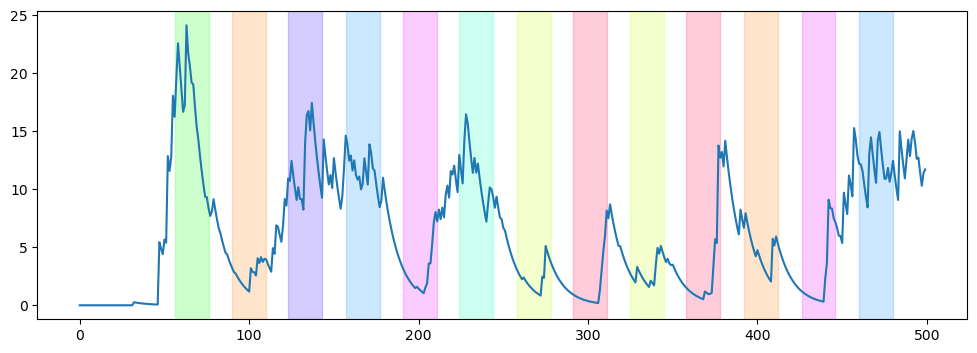

In [129]:
t1, t2 = 0, 500
vis_presentation_window = np.array([0, 20])

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(d.C[neuron_index,t1:t2])
for idx, sample, l_angle, r_angle in d.visual_stimuli.itertuples():
    stim_window = sample + vis_presentation_window
    if t1 <= stim_window[0] and t2 >= stim_window[1]:
        ax.axvspan(stim_window[0], stim_window[1], alpha=0.2, color=d.a2c(l_angle))


## proSVD stability

In [130]:
pro = proSVD(k=4, log_level=1)
p = Pipeline([
    CenteringTransformer(),
    pro,
])

p.offline_run_on(d.neural_data);

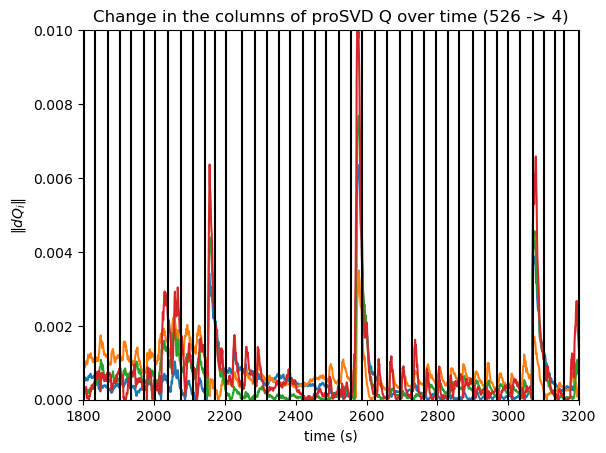

In [131]:
fig, ax = plt.subplots()

pro.plot_Q_stability(ax)

for time in d.opto_stimulations['sample']:
    plt.axvline(time, color='k')
plt.xlim([1800, 3200])
plt.ylim([0, 0.01]);


## TODO: Systematic Drift?

In [132]:
s = d.neural_data.t < d.opto_stimulations['sample'].min()
np.linalg.norm(np.squeeze(d.neural_data.a[s]).mean(axis=0) - np.squeeze(d.neural_data.a[~s]).mean(axis=0))
np.linalg.norm(np.squeeze(d.neural_data.a[~s]).std(axis=0))



np.float64(34.782144933248475)

## Reactions to stim in latent space

In [133]:
smoothing_factor = 2

centerer = CenteringTransformer()
pro = proSVD(k=10)

p = Pipeline([
    centerer,
    pro,
    KernelSmoother(smoothing_factor),
])

s = d.neural_data.t < d.opto_stimulations['sample'].min()
first_part_data = NumpyTimedDataSource(d.neural_data.a[s], d.neural_data.t[s])
second_part_data = NumpyTimedDataSource(d.neural_data.a[~s], d.neural_data.t[~s])


first_part_streams = p.offline_run_on(first_part_data, convinient_return=False)

centerer.freeze(True)
pro.freeze(True)
whole_offline_streams = Pipeline([centerer, pro, KernelSmoother(smoothing_factor),]).offline_run_on(d.neural_data, convinient_return=False)
centerer.freeze(False)
pro.freeze(False)

whole_offline_streams[0] = [x for x in whole_offline_streams[0] if not np.isnan(x).any()]
offline_t = np.array([x.t for x in whole_offline_streams[0]])
offline_output = np.squeeze(whole_offline_streams[0])

second_part_streams = p.offline_run_on(second_part_data, convinient_return=False)
assert set(first_part_streams.keys()) == set(second_part_streams.keys())
united_streams = {k: first_part_streams[k] + second_part_streams[k] for k in first_part_streams.keys()}

l = [x for x in united_streams[0] if not np.isnan(x).any()]
online_t = np.array([x.t for x in l])
online_output = np.squeeze(l)


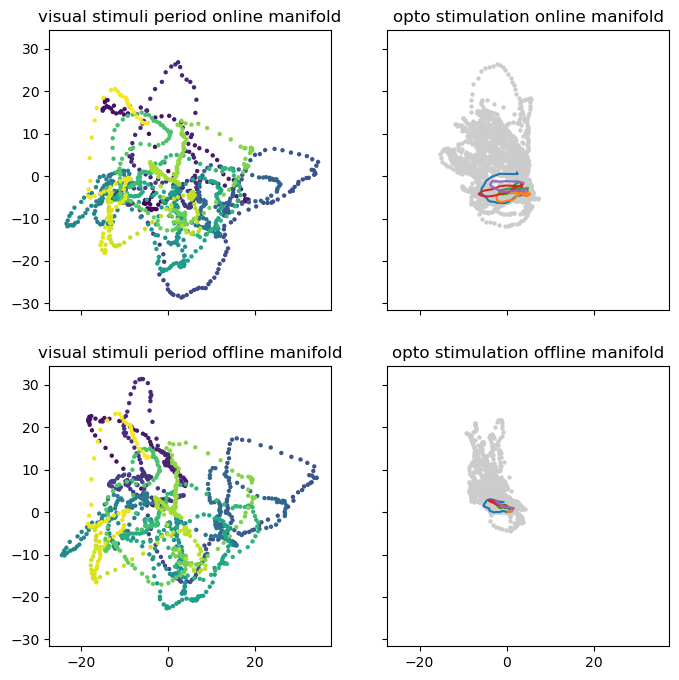

In [134]:
k = 10

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(8,8))
axis_0, axis_1 = 0,1

for row, output, t in [ (0, online_output, online_t), (1, offline_output, offline_t)]:
    lineness = {0: 'online', 1: 'offline'}.get(row)

    s = t < d.opto_stimulations.loc[0, 'sample']
    axs[row,0].scatter(output[s,axis_0], output[s,axis_1], s=10, c=t[s], lw=0)
    axs[row,1].scatter(output[~s,axis_0], output[~s,axis_1], s=10, lw=0, color=np.array([1,1,1])*.8,)

    r = np.arange(5*k,5*k+5)
    assert np.std(d.opto_stimulations.loc[r, 'target_neuron']) == 0
    for i in r:
        s = (d.opto_stimulations.loc[i, 'sample'] <= t) & (t <= d.opto_stimulations.loc[i, 'sample'] + 34)
        axs[row,1].plot(output[s,axis_0], output[s,axis_1])
        
    axs[row,0].set_title(f'visual stimuli period {lineness} manifold')
    axs[row,1].set_title(f'opto stimulation {lineness} manifold')



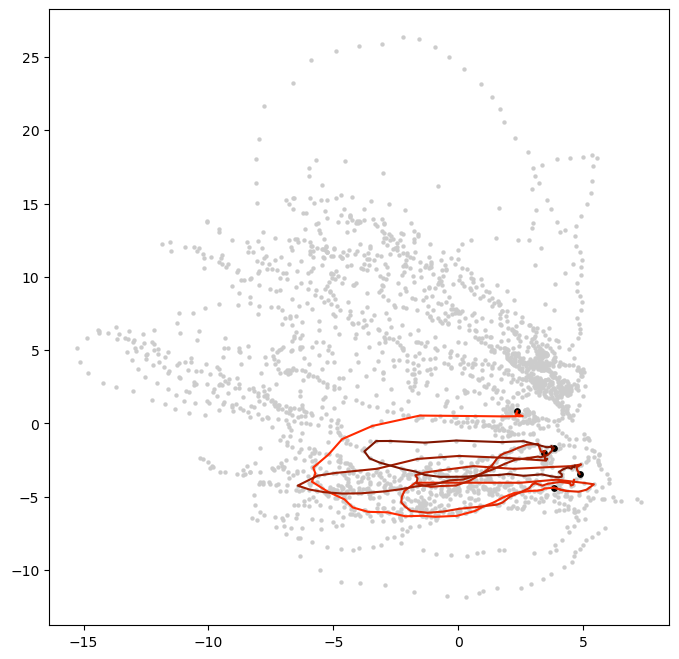

In [183]:

k = 10

output, t = (offline_output, offline_t) if False else (online_output, online_t)
# output, t = 

fig, ax = plt.subplots(figsize=(8,8))
s = t > d.opto_stimulations.loc[0, 'sample']
ax.scatter(output[s,0], output[s,1], s=10, lw=0, color=np.array([1,1,1])*.8,)
r = np.arange(5*k,5*k+5)
assert np.std(d.opto_stimulations.loc[r, 'target_neuron']) == 0
for ii, i in enumerate(r):
    start = int(d.opto_stimulations.loc[i, 'sample'])
    s = (start <= t) & (t <= start + 34)
    ax.plot(output[s,axis_0], output[s,axis_1], color=matplotlib.colors.hsv_to_rgb(np.array([10/360, 1, (8-ii)/8])))
    
    start_idx = np.nonzero(s)[0][0]
    ax.scatter(output[start_idx, axis_0], output[start_idx,axis_1], c='k', s=15)
    # ax.arrow(x = output[start_idx, 0], y = output[start_idx, 1], dx = output[start_idx+1, 0] - output[start_idx, 0], dy= output[start_idx+1, 1] - output[start_idx, 1], zorder=2, length_includes_head=True, head_width=.2, color='k') 

fig.savefig(adaptive_latents.CONFIG['plot_save_path'] / "plot.svg")



## Requests from Anne
* train on visual, project everything
* train on everything, project everything
* ignore visual, train and project
for each,
    * eigenspectra
    * scatterplot visual an photostim 


In [114]:
s = d.neural_data.t < d.opto_stimulations['sample'].min()
first_part_data = NumpyTimedDataSource(d.neural_data.a[s], d.neural_data.t[s])
second_part_data = NumpyTimedDataSource(d.neural_data.a[~s], d.neural_data.t[~s])

In [115]:
p = Pipeline([
    CenteringTransformer(),
    proSVD(k=10),
])
p.offline_run_on(d.neural_data)

p.freeze(True)
output = p.offline_run_on(d.neural_data, convinient_return=False)[0]
p.freeze(False)
output = [x for x in output if not np.isnan(x).any()]
output, t = np.squeeze(output), np.squeeze([x.t for x in output])

In [116]:
d.sub_dataset

'output_020424_ds1'

In [117]:
interesting_combinations = {}
if d.sub_datasets.index(d.sub_dataset) == 2:
    interesting_combinations = {
        "two planes": [
            (1, 3, 6),
            (0, 5, 6),
            (2, 6, 9),
        ],
        "other": [
            (1, 6, 9),
            (0, 6, 9),
            (6, 7, 8),
        ],
        "clam_shapes": [
            (1, 6, 9),
            (0, 3, 6),
            (2, 3, 6),
            (2, 6, 7),
            (0, 4, 6),
            (4, 5, 6),
            (5, 6, 7),
            (3, 5, 6),
            (0, 6, 7),
            (0, 6, 8),
            (0, 2, 6),
            (1, 2, 6),
            (3, 4, 6),
            (6, 8, 9),
        ]
    }
elif d.sub_datasets.index(d.sub_dataset) == 0:
    interesting_combinations = {
        "two planes": [
            (0, 4, 9),
            (0, 5, 8),
            (0, 5, 9), # i guess
        ],
        "plane and a line": [
            (1, 3, 9),
        ],
    }

all_combination_iter = list(itertools.combinations(range(10), 3))
interesting_combinations_iter = [leaf for tree in interesting_combinations.values() for leaf in tree]
combinations = interesting_combinations_iter if False else all_combination_iter
combinations = iter(tqdm.tqdm(combinations))

  0%|          | 0/120 [00:00<?, ?it/s]

In [118]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

axis_0, axis_1, axis_2 = next(combinations)


s = t < d.opto_stimulations['sample'].min()
ax.scatter(output[s,axis_0], output[s,axis_1], output[s,axis_2], s=7)
ax.scatter(output[~s,axis_0], output[~s,axis_1], output[~s,axis_2], s=7)

ax.set_title(d.sub_dataset + " slices")
ax.set_xlabel(f'x: {axis_0}')
ax.set_ylabel(f'y: {axis_1}')
ax.set_zlabel(f'z: {axis_2}')
ax.axis('equal');

In [119]:
def pca(x):
    u, s, vh = np.linalg.svd(x - x.mean(axis=0), full_matrices=False)
    # s = s/x.shape[0]
    s = s
    s_slice = s > 1e-10
    return u[:, s_slice], s[s_slice], vh.T[:, s_slice]

first_part_slice = d.neural_data.t < d.opto_stimulations['sample'].min()

a = np.squeeze(d.neural_data.a)


a = np.vstack([rng.normal(size=(100,5)), 1*rng.normal(size=(50,5))])
first_part_slice = np.arange(a.shape[0])
first_part_slice[first_part_slice < 100] = 1

u0, s0, v0 = pca(a)
u1, s1, v1 = pca(a[first_part_slice])
u2, s2, v2 = pca(a[~first_part_slice])



Text(0, 0.5, 'cumulative variance explained')

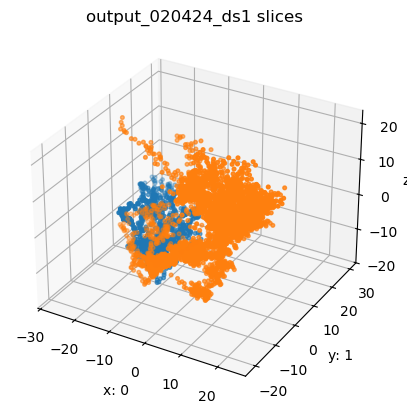

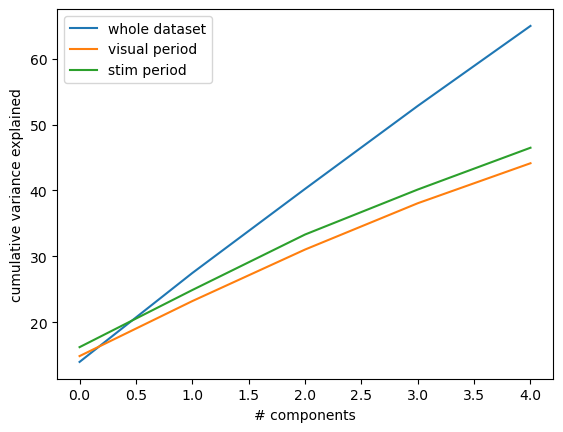

In [120]:
%matplotlib inline
fig, ax = plt.subplots()

x0, x1, x2 = [np.arange(s.size) for s in [s0, s1, s2]]
y0, y1, y2 = [np.cumsum(s) for s in [s0, s1, s2]]


ax.plot(x0, y0, label='whole dataset')
ax.plot(x1, y1, label='visual period')
ax.plot(x2, y2, label='stim period')
ax.legend()
ax.set_xlabel("# components")
ax.set_ylabel("cumulative variance explained")



In [121]:
u, s, vh = np.linalg.svd(v1[:,:10].T @ v2[:,:10])
print(s)

i = [0, -1,-2]
recombined_1 = v1[:,:10] @ u[:,i] 
recombined_2 = v2[:,:10] @ vh[i].T
(recombined_1).T @ (recombined_2)

[1. 1. 1. 1. 1.]


array([[ 1.00000000e+00, -9.54387318e-16,  1.44307573e-16],
       [-2.71480016e-16,  1.00000000e+00,  7.97099106e-17],
       [-5.15278834e-16, -2.12071233e-16,  1.00000000e+00]])

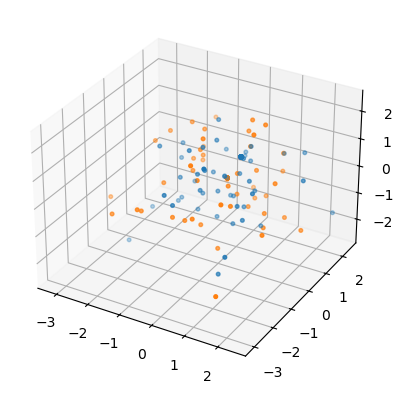

In [122]:
# %matplotlib qt
proj = a @ v0

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[first_part_slice,0], proj[first_part_slice,1], proj[first_part_slice,2], s=7)
ax.scatter(proj[~first_part_slice,0], proj[~first_part_slice,1], proj[~first_part_slice,2], s=7)


In [123]:
d.sub_dataset

'output_020424_ds1'

## Neuron locations

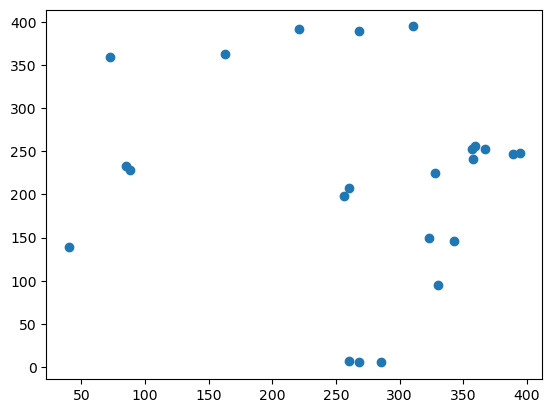

In [124]:
%matplotlib inline
plt.scatter(d.neuron_df['x'], d.neuron_df['y'])

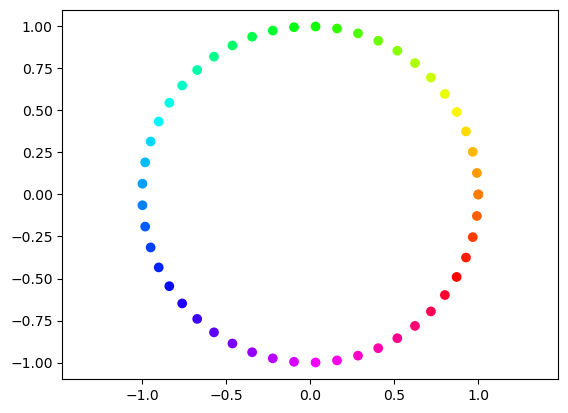

In [125]:
%matplotlib inline
fig, ax = plt.subplots()
d.plot_colors(ax)